In [1]:
import h5py
import numpy as np
import glob
import datetime as datetime
import pickle
import collections
import multiprocessing
import types
import copy
import time
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


In [2]:
def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr


def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr


def read_and_filter_files(c):
    
    # make output containers
    num_chan = c.channels[1] - c.channels[0]
    batch_data = np.zeros((c.samples_per_batch,num_chan))
    batch_timestamps = []
    
    # design the filter
    b,a = butter(2,(c.freq[0],c.freq[1]),'bp',fs=c.fs*2)
    
    for i,file in enumerate(c.batch):
        with h5py.File(file,"r") as f:
            
            # read the data and extract timing information
            data_filt = np.array(f['Acquisition/Raw[0]/RawData'][:,c.channels[0]:c.channels[1]])
            timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
            batch_timestamps.extend(timestamps)

            # filter the data
            data_filt = filtfilt(b,a,data_filt,axis=0)

            # check length of files
            win_start = i*c.samples_per_file
            win_end = (i+1)*c.samples_per_file
            if data_filt.shape[0] > c.samples_per_file:
                batch_data[win_start:win_end,:] = data_filt[:c.samples_per_file,:]
            elif data_filt.shape[0] == c.samples_per_file:
                batch_data[win_start:win_end,:] = data_filt
            elif data_filt.shape[0] < c.samples_per_file:
                batch_data[win_start:win_start+data_filt.shape[0],:] = data_filt   
        f.close()
        
    return batch_data,batch_timestamps


def correlate_templates(c):

    # read the relevant preprocessed file
    data_filt,timestamps = read_and_filter_files(c)
    #plt.plot(data_filt[:,500])
    #plt.show()
    
    # run template matching code for each template
    c.corrs = []
    for template in c.templates:
        c.corrs.append(window_and_correlate(template_filt,data_filt))

    # get start and endtime for saving
    c.datetimes = [datetime.datetime.fromtimestamp(t/1000000) for t in timestamps] #this time is in seattle time
    starttime = c.datetimes[0]
    endtime = c.datetimes[-1]
    c.datestring = starttime.strftime("%Y-%m-%dT%H:%M:%S")+"-"+endtime.strftime("%Y-%m-%dT%H:%M:%S")

    # do triggering
    c.detections = detect(c)
    
    return c


def save_correlations(c):

    # save result for this file
    fname = (c.out_path + c.datestring + "_corr.h5")

    # save array of correlations to h5
    with h5py.File(fname,"w") as f:
        for i,corr in enumerate(c.corrs):
            name = "template_"+str(i)+"_corr"
            f[name] = corr
    f.close()
    
# fuction to read and filter templates
def read_filter_template(fname,c,template_lims):
    file = h5py.File(fname,'r')
    data = np.array(file['Acquisition/Raw[0]/RawData'][:,c.channels[0]:c.channels[1]])
    file.close()
    b,a = butter(2,(c.freq[0],c.freq[1]),'bp',fs=c.fs)
    template_filt = filtfilt(b,a,data,axis=0)
    template_filt = template_filt[template_lims[0]*c.fs:template_lims[1]*c.fs,:]
        
    return template_filt 

In [3]:
# this probably works for "same" correlation but might not for "full"! Should make sure behavior is correct for both..
def trigger(corr,t,corr_threshold,num_triggers_threshold):
    num_windows = corr.shape[0]
    triggers = []
    for w in range(num_windows):
        max_corr = np.max(np.abs(corr[w,:,:]),axis=0)
        num_triggers = np.sum(max_corr > corr_threshold)
        if num_triggers > num_triggers_threshold:
            triggers.append(t[w*corr.shape[1]])
    return triggers


def detect(c):

    # make output container
    detections = {}
    for i in range(c.num_templates):
         detections['template_'+str(i)+"_detections"] = []

    # get correlation functions for each template
    for i in range(c.num_templates):
        key = 'template_'+str(i)+"_corr"
        corr = c.corrs[i]
        triggers = trigger(corr,c.datetimes,c.corr_threshold,c.num_triggers_threshold)
        detections['template_'+str(i)+"_detections"].extend(triggers)

    return detections

In [4]:
'''

Select templates

'''
##For Oso cluster, we will use one event record (I didnt find more)
# make correlation parameter object
c = types.SimpleNamespace()

# set data and filtering parameters
c.freq = [1,10]
c.channels = [100,200]
c.fs = 100

# choose template files and time limits for each template
path = '/data/fast0/veronica-scratch/'
fnames = ['uw61832097.h5'] #, 'uw61901421.h5', 'uw61898286.h5']
template_lims_list = [[51,55]] #,[13,23],[14,24]] # in seconds

# read and filter each template
templates = []
for i,f in enumerate(fnames):
    template_filt = read_filter_template(path+f,c,template_lims_list[i])
    templates.append(template_filt)

# add template defined above
c.templates = templates

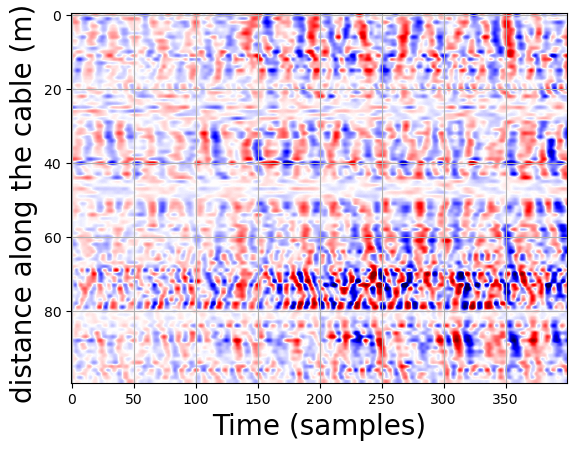

In [5]:
plt.imshow(c.templates[0].T,cmap='seismic',aspect='auto',vmin=-0.8,vmax=0.8)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("distance along the cable (m) ", fontsize=20)
plt.grid()
plt.show()

In [6]:
'''

Set parameters for template matching

'''



# choose channels
##
c.channels = [100,200]
#start_time = datetime.datetime(2022, 5, 17, 0, 0)
#start_string = start_time.strftime("%Y-%m-%d")
# list all the files #version with Steph
#data_paths = ['/data/data5/Converted/whidbey','/data/data6/whidbey/']
#files = []
#for path in data_paths:
#    files.extend(glob.glob(path+"whidbey"+"*.h5"))
#remove_ind = ["lf" in f for f in files]
#files = np.array(files)[~np.array(remove_ind)]
#files.sort()

# remove a region of known non-continuous files
#files = files[11:]


# take the files corresponding to 2022-03-22 (first full day of data)
#run_files = files[414:1854]
##


#I should modify run files to choose the dates that I want to run my template matching, for example, the template 
#was May 17, 2022 to the test correlation values I should try to 
#Other events in oso are [uw61832102, uw61832097,uw6184612, uw61832142,uw61841171, uw61862841,uw61862841, uw61862591]
start_time = datetime.datetime(2022, 5, 17, 0, 0)
start_string = start_time.strftime("%Y-%m-%d")
data_paths = ['/data/data5/Converted/whidbey', '/data/data6/whidbey/']
files = []

for path in data_paths:
    files.extend(glob.glob(path + "_" + start_string + "*h5"))  # Agregar guion bajo aquí
files.sort
run_files =files


# choose batch size (duration of window we´re template matching in)
c.batch_size = 10 # in minutes
c.samples_per_batch = c.batch_size*60*c.fs
c.samples_per_file = 60*c.fs

# get batches
num_files = len(run_files)
remainder = np.mod(num_files,c.batch_size)
if remainder == 0:
    batches = np.reshape(run_files,((num_files)//c.batch_size,c.batch_size))
else:
    batches = np.reshape(run_files[:-remainder],((num_files-remainder)//c.batch_size,c.batch_size))

# choose output direction
c.out_path = "correlation_sametemplate/"

# choose number of processors
c.n_procs = 24

# set triggering parameters
c.num_templates = 1 #number of templates required to say if a detection or not
c.corr_threshold = 0.60 #random value for now
c.num_triggers_threshold = 50 # numbers of channels that we required see the signal

In [ ]:
'''

Run the template matching code in parallel

'''

# clock the program
t = time.time()

# construct iterable list of detection parameter objects for imap
inputs = []
for b in batches:

    # add to detection input list
    c.batch = b
    inputs.append(copy.deepcopy(c))

    # to run in serial (one by one), uncomment the lines below
    #result = correlate_templates(c)
    #save_correlations(result)

# map inputs to correlate_templates and save as each call finishes
if __name__ == '__main__':

    multiprocessing.freeze_support()
    p = multiprocessing.Pool(processes=c.n_procs)
    for result in p.imap_unordered(correlate_templates,inputs):
        save_correlations(result)
    p.close()
    p.join()
    
# check the timing
#sec_per_batch = time.time()-t
#print("Processed",len(inputs),"batches in",sec_per_batch,"seconds")
#batch_per_day = 60*24/len(inputs)
#sec_per_day = sec_per_batch*batch_per_day
#print("One-day estimate:",sec_per_day/60/60,"hours")
#print("Crude 9-month estimate:",9*30*sec_per_day/60/60/24,"days")

/tmp/ipykernel_585255/1231240619.py:30: RuntimeWarning: invalid value encountered in true_divide
  norm_corr = np.real(corr) / norm_factor


In [ ]:
# Acc to the dictionary
detections_dict = result.detections

# Iterar a través de las claves y valores en el diccionario
for template_key, detections_list in detections_dict.items():
    print(f"Template: {template_key}")
    print("Detections:", detections_list)
    print("-----------------------")

In [ ]:
result.corrs